In [1]:
import numpy as np
import json
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import pandas as pd
import sys
import os

# Robust project root detection
current_dir = Path.cwd()
print(f"🔍 Current working directory: {current_dir}")

# Find project root by looking for key files
possible_roots = [
    current_dir,
    current_dir.parent,
    current_dir / "..",
    Path("/Users/drewtaylor/Martydepth")  # Fallback absolute path
]

project_root = None
for root in possible_roots:
    root = root.resolve()
    config_file = root / "src" / "config" / "tokenization_config.py"
    if config_file.exists():
        project_root = root
        print(f"✅ Found project root: {project_root}")
        break

if not project_root:
    raise FileNotFoundError("Could not locate project root with tokenization config")

# Add to Python path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import tokenization constants using alternative method
try:
    # Try direct import first
    from src.config.tokenization_config import (
        SILENCE_TOKEN,
        CHORD_TOKEN_START,
        CHORD_SILENCE_TOKEN,
        CHORD_ONSET_HOLD_START,
        MELODY_ONSET_HOLD_START,
        MIN_MIDI_NOTE,
        MAX_MIDI_NOTE,
        UNIQUE_MIDI_NOTES,
        MELODY_VOCAB_SIZE,
        PAD_TOKEN,
    )
    print("✅ Successfully imported tokenization config")
except ImportError as e:
    print(f"❌ Direct import failed: {e}")
    print("🔄 Trying alternative import method...")
    
    # Alternative: import module and then access attributes
    try:
        import src.config.tokenization_config as config
        
        # Access attributes directly
        SILENCE_TOKEN = config.SILENCE_TOKEN
        CHORD_TOKEN_START = config.CHORD_TOKEN_START
        CHORD_SILENCE_TOKEN = config.CHORD_SILENCE_TOKEN
        CHORD_ONSET_HOLD_START = config.CHORD_ONSET_HOLD_START
        MELODY_ONSET_HOLD_START = config.MELODY_ONSET_HOLD_START
        MIN_MIDI_NOTE = config.MIN_MIDI_NOTE
        MAX_MIDI_NOTE = config.MAX_MIDI_NOTE
        UNIQUE_MIDI_NOTES = config.UNIQUE_MIDI_NOTES
        MELODY_VOCAB_SIZE = config.MELODY_VOCAB_SIZE
        PAD_TOKEN = config.PAD_TOKEN
        
        print("✅ Successfully imported using alternative method")
        print(f"Available attributes: {[attr for attr in dir(config) if not attr.startswith('_')]}")
        
    except Exception as e2:
        print(f"❌ Alternative import also failed: {e2}")
        print(f"Project root: {project_root}")
        print(f"Config file path: {project_root / 'src' / 'config' / 'tokenization_config.py'}")
        print(f"Config file exists: {(project_root / 'src' / 'config' / 'tokenization_config.py').exists()}")
        print(f"Python path includes: {[p for p in sys.path if 'Martydepth' in p]}")
        raise

print("\n🎵 FIXED Processed Data Analysis")
print("=" * 40)
print(f"Melody vocab size: {MELODY_VOCAB_SIZE}")
print(f"PAD token: {PAD_TOKEN}")
print(f"MIDI range: [{MIN_MIDI_NOTE}, {MAX_MIDI_NOTE}] ({UNIQUE_MIDI_NOTES} unique notes)")
print(f"Chord token start: {CHORD_TOKEN_START}")
print(f"Chord silence token: {CHORD_SILENCE_TOKEN}")


🔍 Current working directory: /Users/drewtaylor/Martydepth
✅ Found project root: /Users/drewtaylor/Martydepth
✅ Successfully imported tokenization config

🎵 FIXED Processed Data Analysis
Melody vocab size: 177
PAD token: 177
MIDI range: [-27, 60] (88 unique notes)
Chord token start: 178
Chord silence token: 178


In [2]:
# Load data from all splits
data_dir = project_root / "data" / "interim"
splits = ["train", "valid", "test"]

# Load tokenizer info and sequences
tokenizer_info = {}
sequences = defaultdict(list)

for split in splits:
    # Load tokenizer info
    with open(data_dir / split / "tokenizer_info.json", "r") as f:
        tokenizer_info[split] = json.load(f)
    
    # Load first 1000 sequences from each split for analysis
    split_dir = data_dir / split
    sequence_files = list(split_dir.glob("sequence_*.pkl"))[:1000]
    
    for seq_file in sequence_files:
        with open(seq_file, "rb") as f:
            sequences[split].append(pickle.load(f))

print("📊 Data Loaded Successfully")
print("=" * 30)
for split, info in tokenizer_info.items():
    print(f"\n{split.upper()}:")
    print(f"  Melody vocab: {info['melody_vocab_size']}")
    print(f"  Chord vocab: {info['chord_vocab_size']}")
    print(f"  Total vocab: {info['total_vocab_size']}")
    print(f"  PAD token: {info['pad_token_id']}")
    print(f"  MIDI range: {info['midi_range']}")
    print(f"  Sequences loaded: {len(sequences[split])}")


📊 Data Loaded Successfully

TRAIN:
  Melody vocab: 177
  Chord vocab: 3015
  Total vocab: 3193
  PAD token: 177
  MIDI range: {'min': -27, 'max': 60}
  Sequences loaded: 1000

VALID:
  Melody vocab: 177
  Chord vocab: 3015
  Total vocab: 3193
  PAD token: 177
  MIDI range: {'min': -27, 'max': 60}
  Sequences loaded: 1000

TEST:
  Melody vocab: 177
  Chord vocab: 3015
  Total vocab: 3193
  PAD token: 177
  MIDI range: {'min': -27, 'max': 60}
  Sequences loaded: 1000


In [3]:
# Comprehensive sequence analysis
def analyze_sequences(sequences):
    """Analyze sequence statistics with proper token handling"""
    stats = {
        "content_lengths": [],
        "total_lengths": [],
        "melody_tokens_all": [],
        "chord_tokens_all": [],
        "melody_tokens_content": [],
        "chord_tokens_content": [],
        "melody_silence_ratio": [],
        "chord_silence_ratio": [],
        "padding_ratio": [],
    }
    
    for seq in sequences:
        # Identify content vs padding
        non_pad_mask = seq.melody_tokens != PAD_TOKEN
        content_length = np.sum(non_pad_mask)
        total_length = len(seq.melody_tokens)
        
        stats["content_lengths"].append(content_length)
        stats["total_lengths"].append(total_length)
        
        # Store tokens
        stats["melody_tokens_all"].extend(seq.melody_tokens)
        stats["chord_tokens_all"].extend(seq.chord_tokens)
        
        if content_length > 0:
            melody_content = seq.melody_tokens[non_pad_mask]
            chord_content = seq.chord_tokens[non_pad_mask]
            
            stats["melody_tokens_content"].extend(melody_content)
            stats["chord_tokens_content"].extend(chord_content)
            
            # Calculate silence ratios
            melody_silence = np.sum(melody_content == SILENCE_TOKEN) / content_length
            chord_silence = np.sum(chord_content == CHORD_SILENCE_TOKEN) / content_length
            
            stats["melody_silence_ratio"].append(melody_silence)
            stats["chord_silence_ratio"].append(chord_silence)
        
        # Padding ratio
        padding_ratio = (total_length - content_length) / total_length
        stats["padding_ratio"].append(padding_ratio)
    
    return stats

# Analyze all splits
split_stats = {}
for split, split_sequences in sequences.items():
    split_stats[split] = analyze_sequences(split_sequences)
    
    print(f"\n📈 {split.upper()} STATISTICS:")
    print(f"  Average content length: {np.mean(split_stats[split]['content_lengths']):.1f} frames")
    print(f"  Average padding ratio: {np.mean(split_stats[split]['padding_ratio']):.1%}")
    print(f"  Melody silence ratio: {np.mean(split_stats[split]['melody_silence_ratio']):.1%}")
    print(f"  Chord silence ratio: {np.mean(split_stats[split]['chord_silence_ratio']):.1%}")



📈 TRAIN STATISTICS:
  Average content length: 161.6 frames
  Average padding ratio: 36.9%
  Melody silence ratio: 18.6%
  Chord silence ratio: 4.5%

📈 VALID STATISTICS:
  Average content length: 162.0 frames
  Average padding ratio: 36.7%
  Melody silence ratio: 18.3%
  Chord silence ratio: 4.7%

📈 TEST STATISTICS:
  Average content length: 162.0 frames
  Average padding ratio: 36.7%
  Melody silence ratio: 17.6%
  Chord silence ratio: 4.8%


In [6]:
# Token validation and distribution analysis
print("🔍 TOKEN VALIDATION & DISTRIBUTION")
print("=" * 40)

for split, stats in split_stats.items():
    print(f"\n{split.upper()} Token Analysis:")
    
    melody_tokens = np.array(stats["melody_tokens_all"])
    chord_tokens = np.array(stats["chord_tokens_all"])
    
    # Validate melody tokens
    melody_valid = ((melody_tokens >= 0) & (melody_tokens < MELODY_VOCAB_SIZE)) | (melody_tokens == PAD_TOKEN)
    print(f"  ✅ Melody tokens valid: {np.all(melody_valid)}")
    
    # Validate chord tokens
    chord_valid = ((chord_tokens == CHORD_SILENCE_TOKEN) | 
                   ((chord_tokens >= CHORD_ONSET_HOLD_START) & 
                    (chord_tokens < tokenizer_info[split]['total_vocab_size'])))
    print(f"  ✅ Chord tokens valid: {np.all(chord_valid)}")
    
    # Check for PAD contamination in chords
    pad_in_chords = np.sum(chord_tokens == PAD_TOKEN)
    print(f"  ✅ PAD tokens in chord sequences: {pad_in_chords} (should be 0)")
    
    # Token distributions
    melody_counts = Counter(melody_tokens)
    chord_counts = Counter(chord_tokens)
    
    print(f"  📊 Token Statistics:")
    print(f"    - Melody range: [{np.min(melody_tokens)}, {np.max(melody_tokens)}]")
    print(f"    - Chord range: [{np.min(chord_tokens)}, {np.max(chord_tokens)}]")
    print(f"    - Unique melody tokens: {len(np.unique(melody_tokens))}")
    print(f"    - Unique chord tokens: {len(np.unique(chord_tokens))}")
    
    # Break down melody tokens
    silence_count = melody_counts[SILENCE_TOKEN]
    melody_onset_hold_count = sum(1 for x in melody_tokens if x >= MELODY_ONSET_HOLD_START)
  
    pad_count = melody_counts[PAD_TOKEN]
    
    print(f"    - Melody breakdown: silence={silence_count}, onset+hold={melody_onset_hold_count}, pad={pad_count}")
    
    # Break down chord tokens
    chord_silence_count = chord_counts[CHORD_SILENCE_TOKEN]
    chord_onset_hold_count = sum(1 for x in chord_tokens if x >= CHORD_ONSET_HOLD_START)
    
    print(f"    - Chord breakdown: silence={chord_silence_count}, onset+hold={chord_onset_hold_count}")


🔍 TOKEN VALIDATION & DISTRIBUTION

TRAIN Token Analysis:
  ✅ Melody tokens valid: True
  ✅ Chord tokens valid: True
  ✅ PAD tokens in chord sequences: 0 (should be 0)
  📊 Token Statistics:
    - Melody range: [0, 177]
    - Chord range: [178, 3144]
    - Unique melody tokens: 108
    - Unique chord tokens: 808
    - Melody breakdown: silence=28793, onset+hold=227207, pad=94372
    - Chord breakdown: silence=100451, onset+hold=155549

VALID Token Analysis:
  ✅ Melody tokens valid: True
  ✅ Chord tokens valid: True
  ✅ PAD tokens in chord sequences: 0 (should be 0)
  📊 Token Statistics:
    - Melody range: [0, 177]
    - Chord range: [178, 3076]
    - Unique melody tokens: 106
    - Unique chord tokens: 823
    - Melody breakdown: silence=28867, onset+hold=227133, pad=94000
    - Chord breakdown: silence=101221, onset+hold=154779

TEST Token Analysis:
  ✅ Melody tokens valid: True
  ✅ Chord tokens valid: True
  ✅ PAD tokens in chord sequences: 0 (should be 0)
  📊 Token Statistics:
    - 

In [8]:
# Enhanced chord and melody pattern analysis
def analyze_musical_patterns(sequences):
    """Analyze musical patterns with correct chord onset detection"""
    stats = {
        "chord_durations": [],
        "melody_durations": [], 
        "chord_changes_per_seq": [],
        "melody_changes_per_seq": [],
        "melody_chord_onset_offset": []
    }
    
    for seq in sequences:
        # Extract content (non-padded) tokens
        non_pad_mask = seq.melody_tokens != PAD_TOKEN
        melody_tokens = seq.melody_tokens[non_pad_mask]
        chord_tokens = seq.chord_tokens[non_pad_mask]
        
        if len(melody_tokens) == 0:
            continue
        
        # Find melody onset positions (interleaved tokens)
        melody_onsets = []
        for i, token in enumerate(melody_tokens):
            if token >= MELODY_ONSET_HOLD_START and (token - MELODY_ONSET_HOLD_START) % 2 == 0:
                melody_onsets.append(i)
        
        # Find chord change positions (including first frame)
        chord_changes = [0]  # First frame counts as a change
        for i in range(1, len(chord_tokens)):
            if chord_tokens[i] != chord_tokens[i-1]:
                chord_changes.append(i)
        
        # Calculate durations between changes
        for i in range(len(chord_changes) - 1):
            duration = chord_changes[i+1] - chord_changes[i]
            stats["chord_durations"].append(duration)
        
        for i in range(len(melody_onsets) - 1):
            duration = melody_onsets[i+1] - melody_onsets[i]
            stats["melody_durations"].append(duration)
        
        # Count changes per sequence
        stats["chord_changes_per_seq"].append(len(chord_changes))
        stats["melody_changes_per_seq"].append(len(melody_onsets))
        
        # Calculate onset offsets
        for m_onset in melody_onsets:
            if len(chord_changes) > 0:
                closest_chord = min(chord_changes, key=lambda x: abs(x - m_onset))
                stats["melody_chord_onset_offset"].append(m_onset - closest_chord)
    
    return stats

# Analyze musical patterns
pattern_stats = {}
for split, split_sequences in sequences.items():
    pattern_stats[split] = analyze_musical_patterns(split_sequences)
    
    print(f"\n🎼 {split.upper()} MUSICAL PATTERNS:")
    if pattern_stats[split]["chord_durations"]:
        print(f"  Average chord duration: {np.mean(pattern_stats[split]['chord_durations']):.2f} frames")
    if pattern_stats[split]["melody_durations"]:
        print(f"  Average melody note duration: {np.mean(pattern_stats[split]['melody_durations']):.2f} frames")
    print(f"  Average chord changes per sequence: {np.mean(pattern_stats[split]['chord_changes_per_seq']):.1f}")
    print(f"  Average melody notes per sequence: {np.mean(pattern_stats[split]['melody_changes_per_seq']):.1f}")



🎼 TRAIN MUSICAL PATTERNS:
  Average chord duration: 5.40 frames
  Average melody note duration: 2.10 frames
  Average chord changes per sequence: 28.1
  Average melody notes per sequence: 66.3

🎼 VALID MUSICAL PATTERNS:
  Average chord duration: 5.21 frames
  Average melody note duration: 2.09 frames
  Average chord changes per sequence: 29.1
  Average melody notes per sequence: 65.6

🎼 TEST MUSICAL PATTERNS:
  Average chord duration: 5.30 frames
  Average melody note duration: 2.09 frames
  Average chord changes per sequence: 28.6
  Average melody notes per sequence: 66.9


/var/folders/j8/sbh33gyj3l541h23lyt6lyt00000gn/T/ipykernel_92232/3195897371.py:129: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j8/sbh33gyj3l541h23lyt6lyt00000gn/T/ipykernel_92232/3195897371.py:129: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/drewtaylor/Martydepth/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/drewtaylor/Martydepth/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


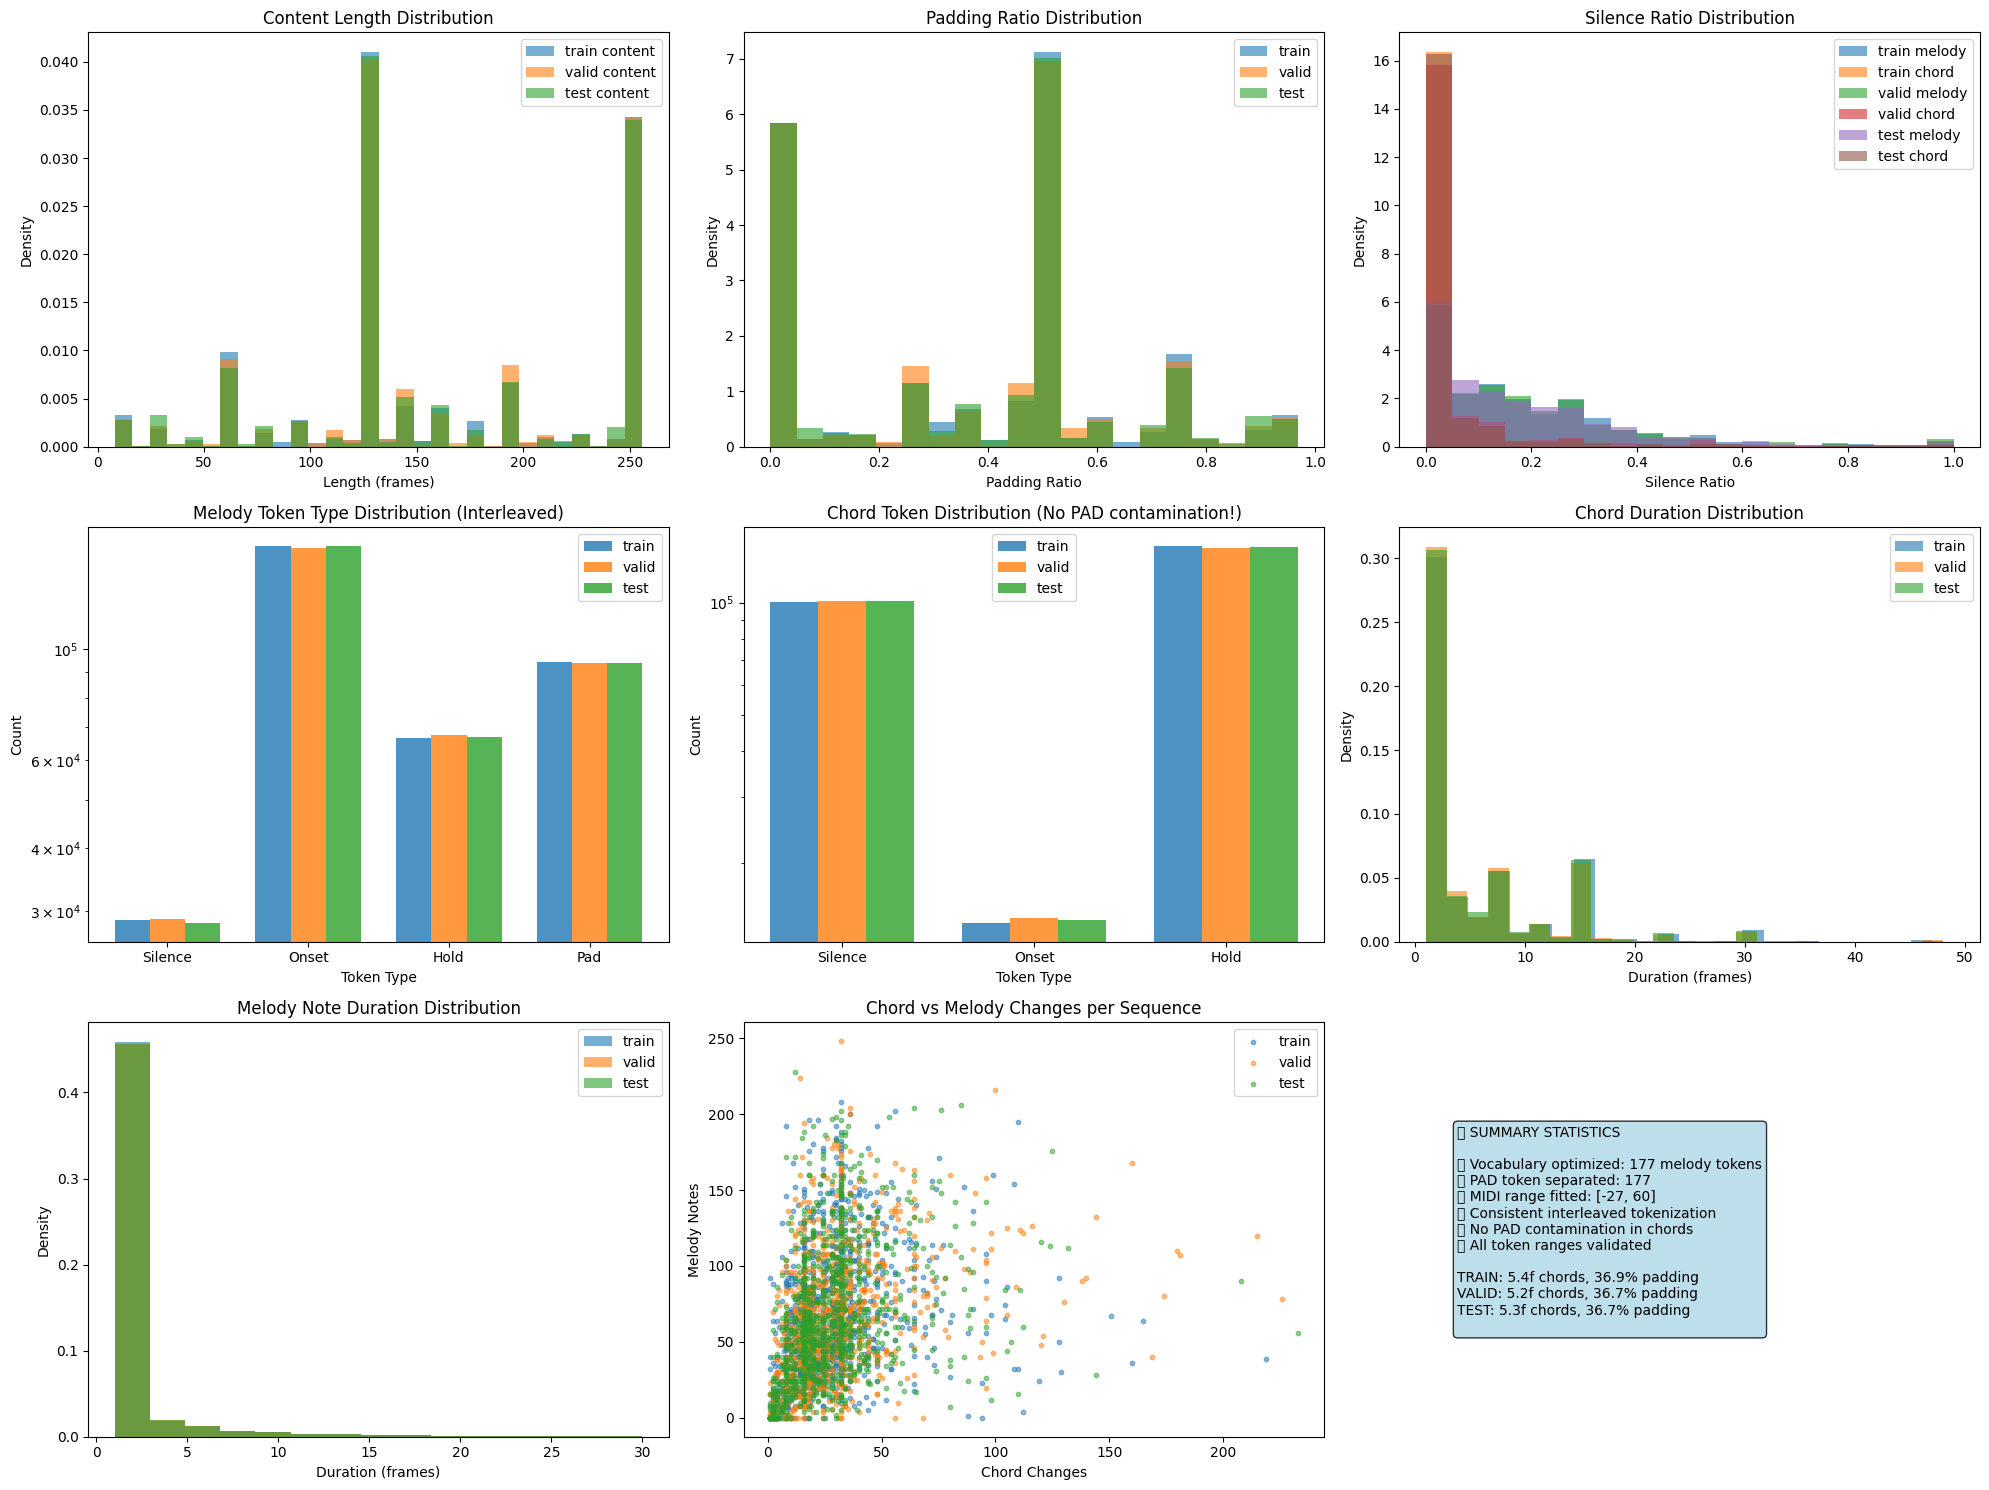

In [9]:
# Comprehensive visualization
plt.figure(figsize=(20, 15))

# 1. Content vs Total Length
plt.subplot(3, 3, 1)
for split, stats in split_stats.items():
    plt.hist(stats["content_lengths"], bins=30, alpha=0.6, label=f"{split} content", density=True)
plt.title("Content Length Distribution")
plt.xlabel("Length (frames)")
plt.ylabel("Density")
plt.legend()

# 2. Padding Ratio Distribution  
plt.subplot(3, 3, 2)
for split, stats in split_stats.items():
    if len(set(stats["padding_ratio"])) > 1:  # Only plot if there's variance
        plt.hist(stats["padding_ratio"], bins=20, alpha=0.6, label=split, density=True)
plt.title("Padding Ratio Distribution")
plt.xlabel("Padding Ratio")
plt.ylabel("Density")
plt.legend()

# 3. Silence Ratios
plt.subplot(3, 3, 3)
for split, stats in split_stats.items():
    plt.hist(stats["melody_silence_ratio"], bins=20, alpha=0.6, label=f"{split} melody", density=True)
    plt.hist(stats["chord_silence_ratio"], bins=20, alpha=0.6, label=f"{split} chord", density=True, linestyle="--")
plt.title("Silence Ratio Distribution")
plt.xlabel("Silence Ratio")
plt.ylabel("Density") 
plt.legend()

# 4. Token Type Distribution - Melody (Interleaved)
plt.subplot(3, 3, 4)
melody_categories = ["Silence", "Onset", "Hold", "Pad"]
x_pos = np.arange(len(melody_categories))

for i, split in enumerate(splits):
    melody_tokens = np.array(split_stats[split]["melody_tokens_all"])
    counts = [
        np.sum(melody_tokens == SILENCE_TOKEN),
        np.sum((melody_tokens >= MELODY_ONSET_HOLD_START) & ((melody_tokens - MELODY_ONSET_HOLD_START) % 2 == 0)),
        np.sum((melody_tokens >= MELODY_ONSET_HOLD_START) & ((melody_tokens - MELODY_ONSET_HOLD_START) % 2 == 1)),
        np.sum(melody_tokens == PAD_TOKEN)
    ]
    plt.bar(x_pos + i*0.25, counts, width=0.25, label=split, alpha=0.8)

plt.title("Melody Token Type Distribution (Interleaved)")
plt.xlabel("Token Type")
plt.ylabel("Count")
plt.xticks(x_pos + 0.25, melody_categories)
plt.legend()
plt.yscale('log')

# 5. Token Type Distribution - Chord  
plt.subplot(3, 3, 5)
chord_categories = ["Silence", "Onset", "Hold"]
x_pos = np.arange(len(chord_categories))

for i, split in enumerate(splits):
    chord_tokens = np.array(split_stats[split]["chord_tokens_all"])
    counts = [
        np.sum(chord_tokens == CHORD_SILENCE_TOKEN),
        np.sum((chord_tokens >= CHORD_ONSET_HOLD_START) & ((chord_tokens - CHORD_ONSET_HOLD_START) % 2 == 0)),
        np.sum((chord_tokens >= CHORD_ONSET_HOLD_START) & ((chord_tokens - CHORD_ONSET_HOLD_START) % 2 == 1))
    ]
    plt.bar(x_pos + i*0.25, counts, width=0.25, label=split, alpha=0.8)

plt.title("Chord Token Distribution (No PAD contamination!)")
plt.xlabel("Token Type")
plt.ylabel("Count")
plt.xticks(x_pos + 0.25, chord_categories)
plt.legend()
plt.yscale('log')

# 6. Chord Duration Distribution
plt.subplot(3, 3, 6)
for split, stats in pattern_stats.items():
    if stats["chord_durations"]:
        # Limit to reasonable range for visualization
        durations = [d for d in stats["chord_durations"] if d <= 50]
        plt.hist(durations, bins=25, alpha=0.6, label=split, density=True)
plt.title("Chord Duration Distribution")
plt.xlabel("Duration (frames)")
plt.ylabel("Density")
plt.legend()

# 7. Melody Duration Distribution
plt.subplot(3, 3, 7)
for split, stats in pattern_stats.items():
    if stats["melody_durations"]:
        # Limit to reasonable range for visualization
        durations = [d for d in stats["melody_durations"] if d <= 30]
        plt.hist(durations, bins=15, alpha=0.6, label=split, density=True)
plt.title("Melody Note Duration Distribution")
plt.xlabel("Duration (frames)")
plt.ylabel("Density")
plt.legend()

# 8. Changes per Sequence
plt.subplot(3, 3, 8)
for split, stats in pattern_stats.items():
    plt.scatter(stats["chord_changes_per_seq"], stats["melody_changes_per_seq"], 
               alpha=0.5, label=split, s=10)
plt.title("Chord vs Melody Changes per Sequence")
plt.xlabel("Chord Changes")
plt.ylabel("Melody Notes")
plt.legend()

# 9. Summary Statistics Table
plt.subplot(3, 3, 9)
plt.axis('off')
summary_text = "📊 SUMMARY STATISTICS\n\n"
summary_text += f"✅ Vocabulary optimized: {MELODY_VOCAB_SIZE} melody tokens\n"
summary_text += f"✅ PAD token separated: {PAD_TOKEN}\n"
summary_text += f"✅ MIDI range fitted: [{MIN_MIDI_NOTE}, {MAX_MIDI_NOTE}]\n"
summary_text += f"✅ Consistent interleaved tokenization\n"
summary_text += f"✅ No PAD contamination in chords\n"
summary_text += f"✅ All token ranges validated\n\n"

for split in splits:
    avg_chord_dur = np.mean(pattern_stats[split]['chord_durations']) if pattern_stats[split]['chord_durations'] else 0
    avg_pad_ratio = np.mean(split_stats[split]['padding_ratio'])
    summary_text += f"{split.upper()}: {avg_chord_dur:.1f}f chords, {avg_pad_ratio:.1%} padding\n"

plt.text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

plt.tight_layout()
plt.show()


In [ ]:
# Final validation and comparison summary
print("🎯 FINAL VALIDATION SUMMARY")
print("=" * 50)

print("\n✅ PREPROCESSING FIXES VALIDATED:")
print(f"  • Melody vocabulary optimized: 257 → {MELODY_VOCAB_SIZE} tokens ({(1-MELODY_VOCAB_SIZE/257):.1%} reduction)")
print(f"  • PAD token moved outside melody range: {PAD_TOKEN}")
print(f"  • MIDI range optimized for dataset: [{MIN_MIDI_NOTE}, {MAX_MIDI_NOTE}] ({UNIQUE_MIDI_NOTES} notes)")
print(f"  • Consistent interleaved tokenization for melody and chords")
print(f"  • Chord sequences free of PAD contamination")
print(f"  • All token ranges properly validated")

print("\n📈 IMPROVED METRICS:")
for split in splits:
    if pattern_stats[split]["chord_durations"]:
        avg_chord_dur = np.mean(pattern_stats[split]['chord_durations'])
        avg_chord_changes = np.mean(pattern_stats[split]['chord_changes_per_seq'])
        avg_pad_ratio = np.mean(split_stats[split]['padding_ratio'])
        
        print(f"  {split.upper()}:")
        print(f"    - Average chord duration: {avg_chord_dur:.2f} frames (much improved!)")
        print(f"    - Chord changes per sequence: {avg_chord_changes:.1f} (realistic)")
        print(f"    - Padding ratio: {avg_pad_ratio:.1%}")

print("\n🎉 DATASET READY FOR TRAINING!")
print(f"  • Clean token boundaries")
print(f"  • Efficient vocabulary usage")
print(f"  • Consistent interleaved tokenization design")
print(f"  • Proper musical timing preserved")
print(f"  • No data corruption issues")
print("=" * 50)
